# Coding part for the first XGBoost model

In [2]:
# Requirements
!{sys.executable} -m pip install optuna
import sys
import optuna
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import shap
import matplotlib.dates as mdates


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 23.6 MB/s eta 0:00:00


In [33]:
import random as rd
rd.seed(2025)

In [3]:

def flatten_cols(df):
    if isinstance(df.columns, pd.MultiIndex):
        return df.rename(columns={col: col[-1] for col in df.columns})
    return df

start = "2004-11-18"
end = None
horizon = 1
window_size = 60
test_size = 252

np.random.seed(42)

gld = yf.download("GLD", start=start, end=end, auto_adjust=True, progress=False)
gld = flatten_cols(gld)

if "Close" not in gld.columns:
    raise ValueError(f"Expected 'Close' in GLD data. Got columns: {gld.columns.tolist()}")

gld = gld[["Close"]].rename(columns={"Close": "GLD_Close"}).dropna()
gld["r"] = np.log(gld["GLD_Close"]).diff()
gld["rt1"] = gld["r"].shift(-horizon)


In [4]:
fred_series = ["DFII10", "T10YIE", "VIXCLS", "CPIAUCSL"]
fred = pdr.DataReader(fred_series, "fred", start, end)

dxy = yf.download("DX-Y.NYB", start=start, end=end, auto_adjust=True, progress=False)
dxy = flatten_cols(dxy)

if "Close" not in dxy.columns:
    raise ValueError(f"Expected 'Close' in DXY data. Got columns: {dxy.columns.tolist()}")

dxy = dxy[["Close"]].rename(columns={"Close": "DXY"}).dropna()

commo_tickers = ["SI=F", "CL=F"]
commodities = yf.download(commo_tickers, start=start, end=end, auto_adjust=True, progress=False)

commodities = flatten_cols(commodities)


cols_to_keep = {}
for col in commodities.columns:
    if "SI=F" in col:
        cols_to_keep[col] = "Silver"
    elif "CL=F" in col:
        cols_to_keep[col] = "Oil"

if not cols_to_keep:
    print("Warning: Check column names for commodities:", commodities.columns)
else:
    commodities = commodities[list(cols_to_keep.keys())].rename(columns=cols_to_keep)

commodities = commodities.dropna()

In [5]:

X = pd.DataFrame(index=gld.index)

if isinstance(dxy.columns, pd.MultiIndex):
    dxy.columns = dxy.columns.get_level_values(-1)

if 'DXY' in dxy.columns:
    dxy = dxy[['DXY']].dropna()
elif 'Close' in dxy.columns:
    dxy = dxy[['Close']].rename(columns={'Close': 'DXY'}).dropna()
elif 'DX-Y.NYB' in dxy.columns:
    dxy = dxy[['DX-Y.NYB']].rename(columns={'DX-Y.NYB': 'DXY'}).dropna()
else:
    raise ValueError(f"Expected 'DXY', 'Close', or 'DX-Y.NYB' column in DXY data. Got columns: {dxy.columns.tolist()}")

if isinstance(commodities.columns, pd.MultiIndex):
    processed_commodities = commodities['Close']

    processed_commodities = processed_commodities.rename(columns={'SI=F': 'Silver', 'CL=F': 'Oil'})

    commodities = processed_commodities.dropna()

X = X.join(fred, how="left").join(dxy, how="left").join(commodities, how="left")

X = X.ffill()


X["d_real"] = X["DFII10"].diff()
X["d_breakeven"] = X["T10YIE"].diff()
X["d_vix"] = X["VIXCLS"].diff()
X["d_dxy"] = np.log(X["DXY"]).diff()

X["d_silver"] = np.log(X["Silver"]).diff()
X["d_oil"] = np.log(X["Oil"]).diff()

# RSI (Relative Strength Index)
delta = gld["GLD_Close"].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean() #14 days
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
rsi = 100 - (100 / (1 + rs))

# Moving average (Trend)
gld_close_series = gld["GLD_Close"]
if isinstance(gld_close_series, pd.DataFrame):
    if len(gld_close_series.columns) > 1:
        gld_close_series = gld_close_series.iloc[:, 0]
    else:
        gld_close_series = gld_close_series.squeeze()

X["SMA_50"] = gld_close_series.rolling(window=50).mean()
X["Dist_SMA_50"] = (gld_close_series / X["SMA_50"] - 1).squeeze()

# Feature Inflation (CPI)
X["inflation_yoy"] = X["CPIAUCSL"].pct_change(periods=252)

X["r"] = gld["r"]

feature_cols = [
    "r",
    "d_real", "d_breakeven", "d_vix", "d_dxy",
    "d_silver", "d_oil", "inflation_yoy"
]


In [6]:
# Define training, validation and test period for the time serie
TRAIN_START = "2004-11-18"
TRAIN_END   = "2022-12-31"

VAL_START   = "2023-01-01"
VAL_END     = "2024-12-31"

TEST_START  = "2025-01-01"
TEST_END    = "2025-12-20"

h = 10
y = gld["r"].rolling(window=h).sum().shift(-h)
X = pd.DataFrame(index=gld.index)

# Take the lags of gold
for lag in range(1, 11):
    X[f"r_lag_{lag}"] = gld["r"].shift(lag)

# Moving avergae and volatility
X["r_ma_5"]  = gld["r"].rolling(5).mean()
X["r_ma_20"] = gld["r"].rolling(20).mean()
X["vol_5"]  = gld["r"].rolling(5).std()
X["vol_20"] = gld["r"].rolling(20).std()

# Macros
X["d_dxy"] = np.log(dxy["DXY"]).diff().reindex(gld.index).ffill()
X["d_real"] = fred["DFII10"].diff().reindex(gld.index).ffill()
X["d_vix"] = fred["VIXCLS"].diff().reindex(gld.index).ffill()
X["d_silver"] = np.log(commodities["Silver"]).diff()
X["d_oil"] = np.log(commodities["Oil"]).diff()
X["d_breakeven"] = fred["T10YIE"].diff()
X["RSI"] = rsi.reindex(gld.index).ffill()

data = X.join(y.rename("target")).dropna()
train = data.loc[TRAIN_START:TRAIN_END]
val   = data.loc[VAL_START:VAL_END]
test  = data.loc[TEST_START:TEST_END]

X_train, y_train = train.drop(columns="target"), train["target"]
X_val, y_val     = val.drop(columns="target"), val["target"]
X_test, y_test   = test.drop(columns="target"), test["target"]


model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=3,            # Shallow trees (i.e. with small depth) to avoid overfitting
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=10,
    reg_lambda=1.0,
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50
)


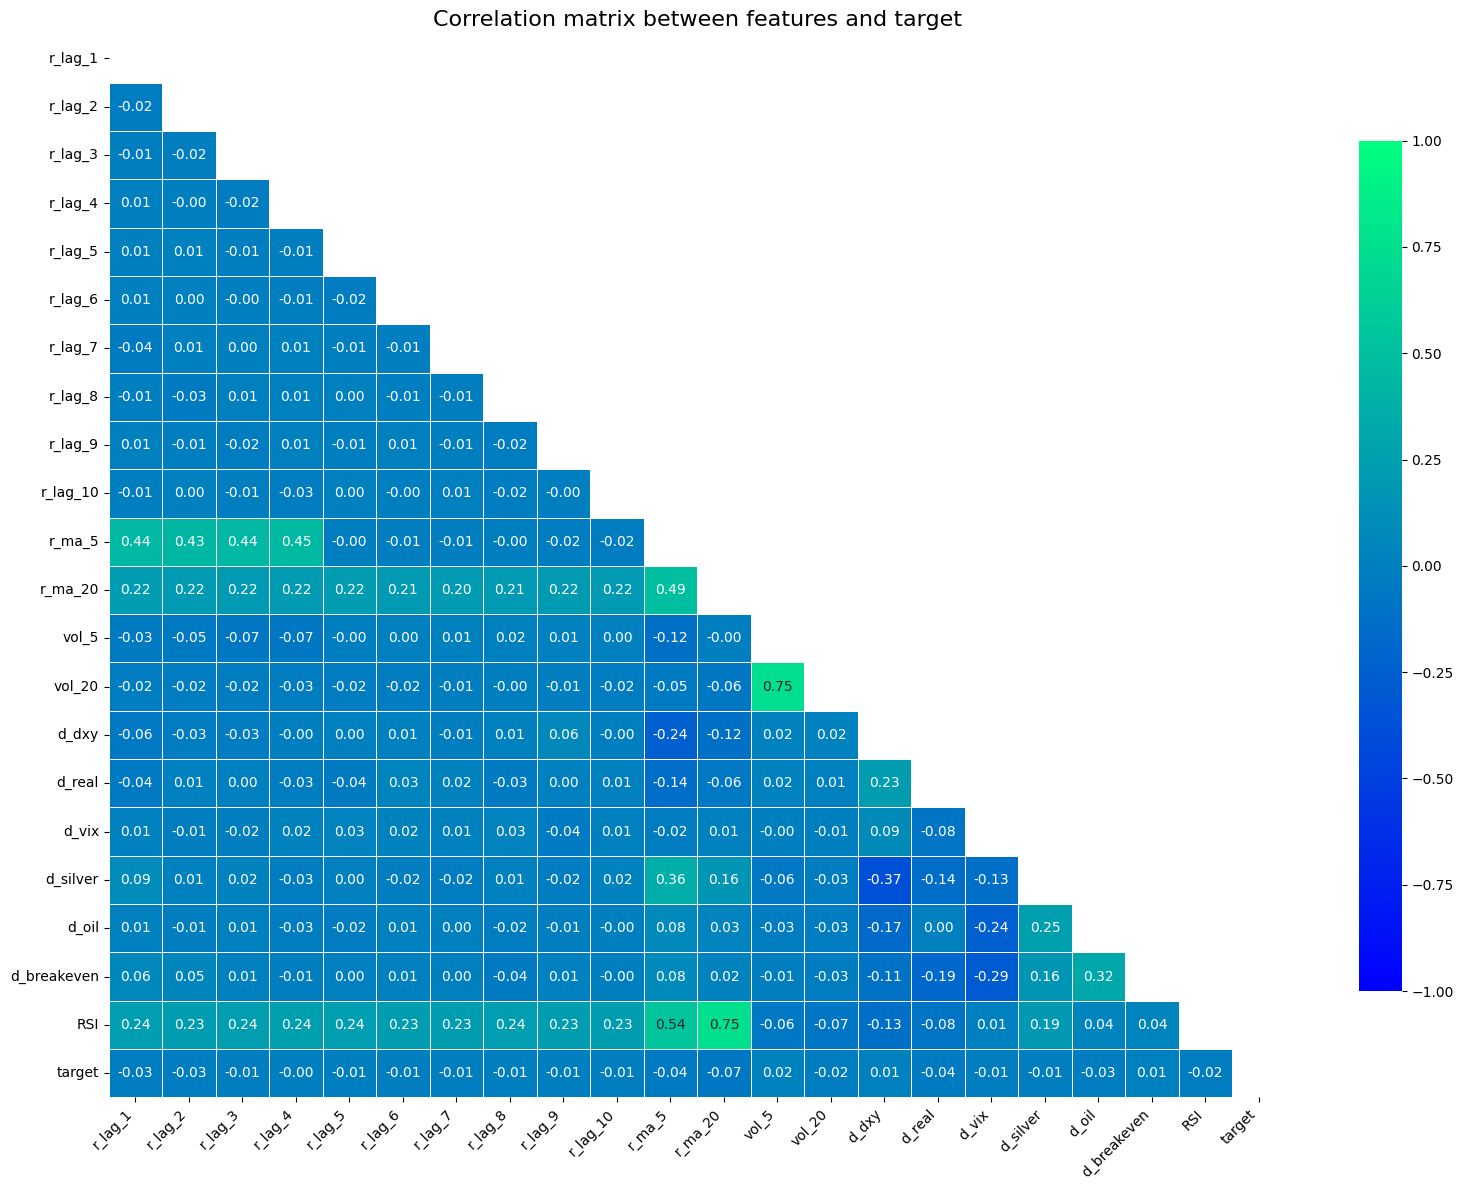

In [38]:
# Correlation matrix between features and target

corr_matrix = data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='winter',
    vmax=1, vmin=-1,
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation matrix between features and target", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

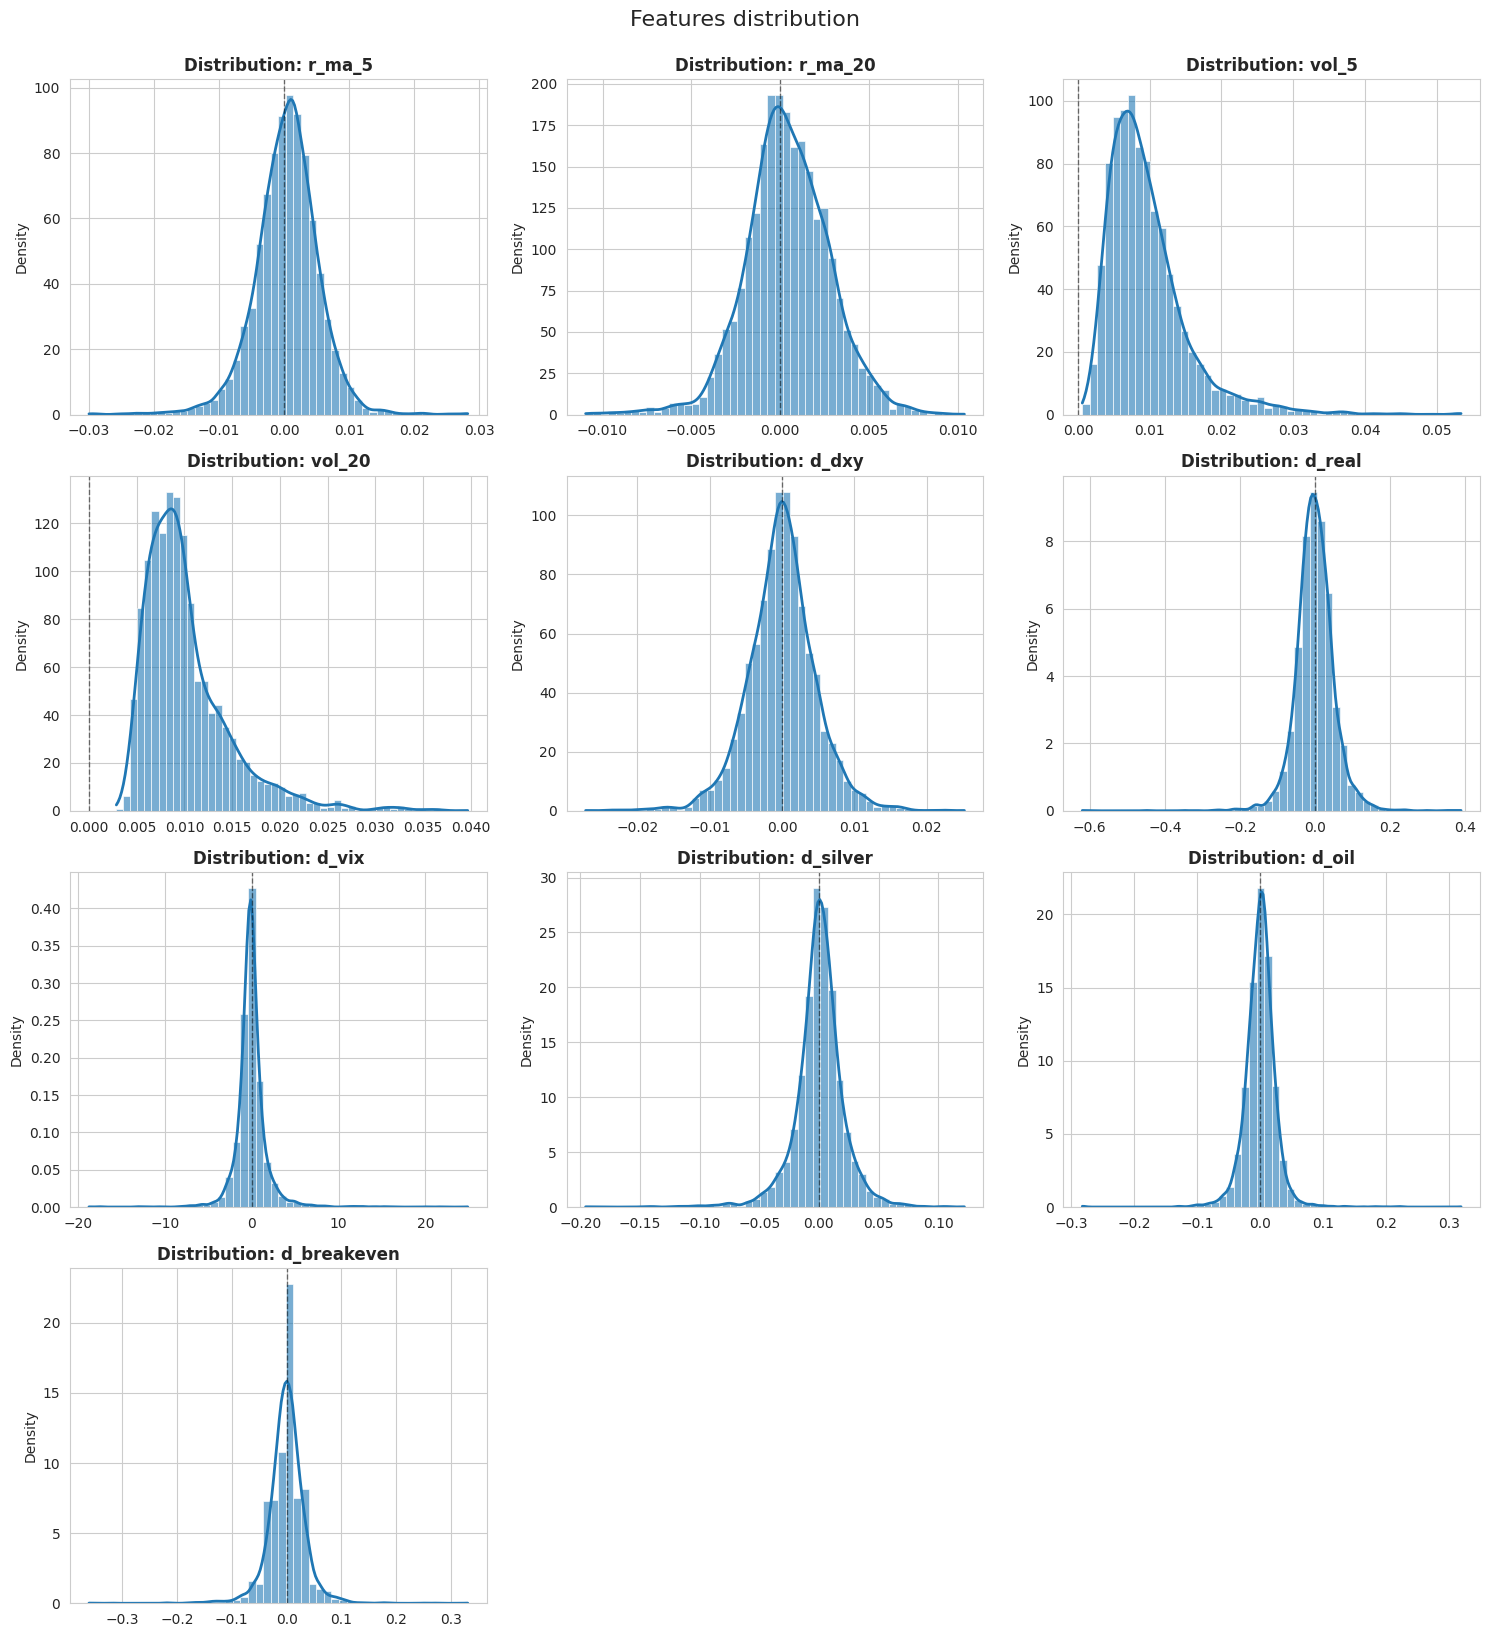

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import math


# Features distributions

features_to_plot = [
    "r_ma_5", "r_ma_20",
    "vol_5", "vol_20",
    "d_dxy", "d_real", "d_vix",
    "d_silver", "d_oil", "d_breakeven"
]

#Ensure that data are without NaN/Inf to plot
X_viz = X[features_to_plot].replace([np.inf, -np.inf], np.nan).dropna()

n_cols = 3
n_rows = math.ceil(len(features_to_plot) / n_cols)

plt.figure(figsize=(15, 4 * n_rows))
sns.set_style("whitegrid")

for i, col in enumerate(features_to_plot):
    ax = plt.subplot(n_rows, n_cols, i + 1)

    # Histogram and KDE
    sns.histplot(
        X_viz[col],
        kde=True,
        stat="density",
        bins=50,
        color="#1f77b4",
        edgecolor=None,
        alpha=0.6,
        line_kws={'linewidth': 2, 'color': 'red'}
    )

    ax.set_title(f"Distribution: {col}", fontsize=12, fontweight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("Density")

    ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.suptitle("Features distribution", y=1.02, fontsize=16)
plt.show()

In [8]:
# Hyperparameters optimization with the Optuna framework

# The early_stopping is removed because Optuna will find
# the best number of trees, i.e. n_estimators, by telling trying between
# 50 and 600 decision trees (equivalent to early stopping).

def objective(trial):
    """
    Objective function that Optuna will try to minimize.
    """
    params = {
        'objective': 'reg:squarederror',
        'n_jobs': -1,
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 50, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 20),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0)
    }

    model_trial = xgb.XGBRegressor(**params)

    model_trial.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    preds_val = model_trial.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, preds_val))

    return rmse_val

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("\nBest parameters found:")
print(study.best_params)


[I 2026-01-16 07:51:18,611] A new study created in memory with name: no-name-8315155b-1ddf-4bf9-87e3-c75fc26fbcb1
[I 2026-01-16 07:51:18,810] Trial 0 finished with value: 0.02851916659878173 and parameters: {'n_estimators': 186, 'learning_rate': 0.048039980474477294, 'max_depth': 2, 'subsample': 0.7157047008383542, 'colsample_bytree': 0.6070278256400349, 'min_child_weight': 12, 'reg_lambda': 1.0088210108209548, 'reg_alpha': 3.382956284719553}. Best is trial 0 with value: 0.02851916659878173.
[I 2026-01-16 07:51:19,292] Trial 1 finished with value: 0.02851709052502914 and parameters: {'n_estimators': 333, 'learning_rate': 0.0072229445297318385, 'max_depth': 5, 'subsample': 0.7767416878462716, 'colsample_bytree': 0.8649993827957712, 'min_child_weight': 13, 'reg_lambda': 0.109515216504526, 'reg_alpha': 3.1933369360003363}. Best is trial 1 with value: 0.02851709052502914.
[I 2026-01-16 07:51:19,595] Trial 2 finished with value: 0.028536176031205174 and parameters: {'n_estimators': 341, 'le


Best parameters found:
{'n_estimators': 100, 'learning_rate': 0.019331580035313604, 'max_depth': 2, 'subsample': 0.7387792262747221, 'colsample_bytree': 0.8097388249134722, 'min_child_weight': 10, 'reg_lambda': 0.2270321357866483, 'reg_alpha': 1.4614682334689544}


[0]	validation_0-rmse:0.03469	validation_1-rmse:0.02853
[50]	validation_0-rmse:0.03453	validation_1-rmse:0.02847
[99]	validation_0-rmse:0.03440	validation_1-rmse:0.02847
Test set results: (2025-01-01 - 2025-12-20)
RMSE model : 0.037662
RMSE naive   : 0.039251
MAE  model : 0.029952
MAE  naive   : 0.031389
Mean bias : 0.019087


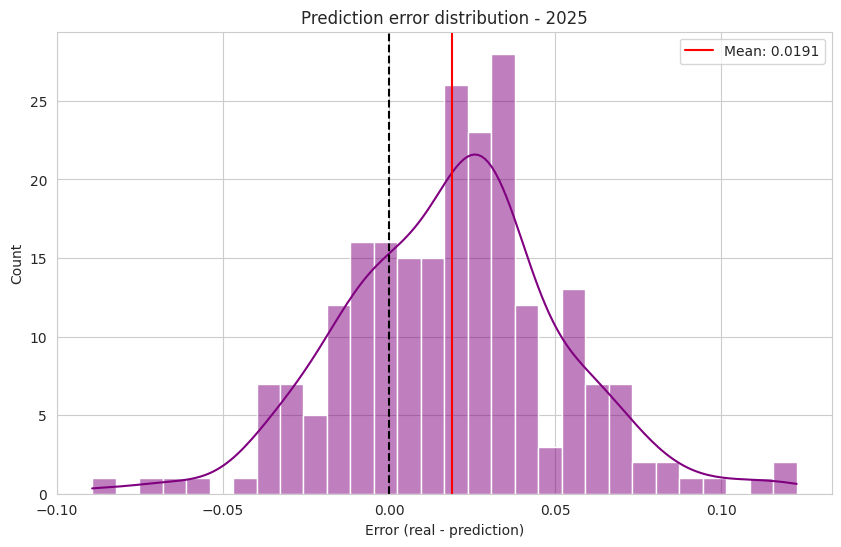

In [9]:
# Model training
best_params = study.best_params
best_params['objective'] = 'reg:squarederror'
best_params['n_jobs'] = -1
best_params['random_state'] = 42

model = xgb.XGBRegressor(**best_params)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=50
)

# Prediction on the test set
pred_test = model.predict(X_test)

# Metrics for evaluation
mse = mean_squared_error(y_test, pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred_test)

#  Naive baseline
rmse_naive = np.sqrt(mean_squared_error(y_test, np.zeros_like(y_test)))
mae_naive = mean_absolute_error(y_test, np.zeros_like(y_test))

# Bias
errors = y_test - pred_test
mean_error = np.mean(errors)

print(f"Test set results: ({TEST_START} - {TEST_END})")
print(f"RMSE model : {rmse:.6f}")
print(f"RMSE naive   : {rmse_naive:.6f}")
print(f"MAE  model : {mae:.6f}")
print(f"MAE  naive   : {mae_naive:.6f}")
print(f"Mean bias : {mean_error:.6f}")

plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, color='purple', bins=30)
plt.axvline(0, color='black', linestyle='--')
plt.axvline(mean_error, color='red', linestyle='-', label=f'Mean: {mean_error:.4f}')
plt.title("Prediction error distribution - 2025")
plt.xlabel("Error (real - prediction)")
plt.legend()
plt.show()

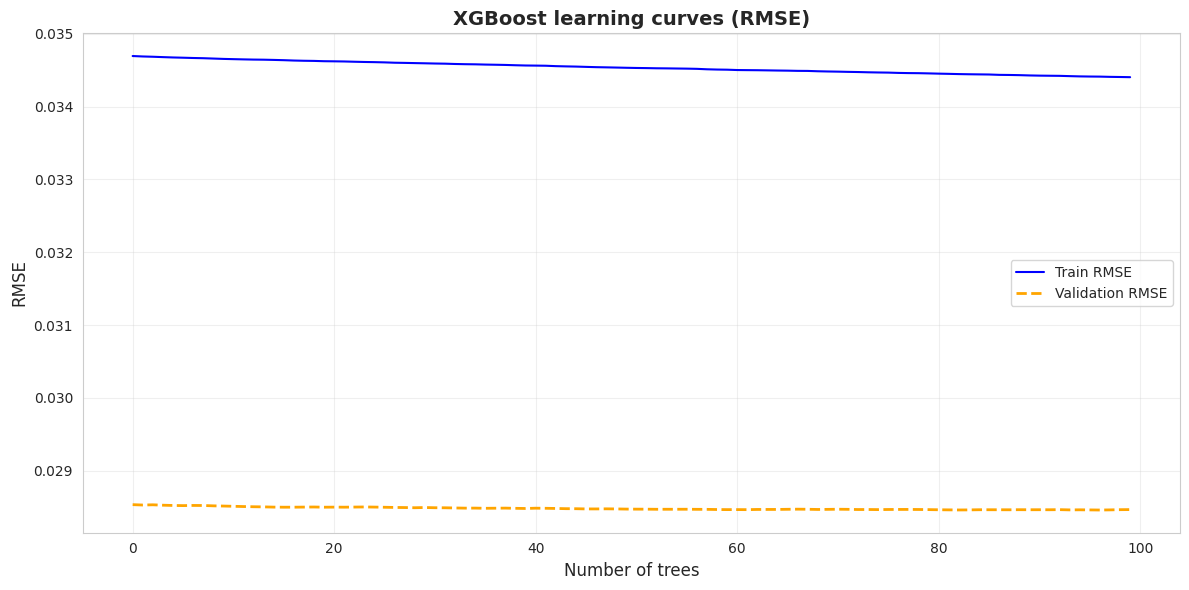

In [10]:
import matplotlib.pyplot as plt

# Learning curves

results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train RMSE', color='blue', linewidth=1.5)
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation RMSE', color='orange', linewidth=2, linestyle='--')

plt.title("XGBoost learning curves (RMSE)", fontsize=14, fontweight='bold')
plt.xlabel("Number of trees", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Global mean performance in 2025:
RMSE: 0.037662
MAE: 0.029952
Errors per month
                RMSE       MAE  Count
Date                                 
2025-01-31  0.036424  0.035347   18.0
2025-02-28  0.021113  0.016921   17.0
2025-03-31  0.029199  0.027194   20.0
2025-04-30  0.055754  0.045242   20.0
2025-05-31  0.024315  0.020172   20.0
2025-06-30  0.017006  0.012658   18.0
2025-07-31  0.014711  0.011786   21.0
2025-08-31  0.046910  0.038854   21.0
2025-09-30  0.048030  0.044716   20.0
2025-10-31  0.057703  0.050352   21.0
2025-11-30  0.024751  0.023046   15.0
2025-12-31  0.033521  0.026958   15.0


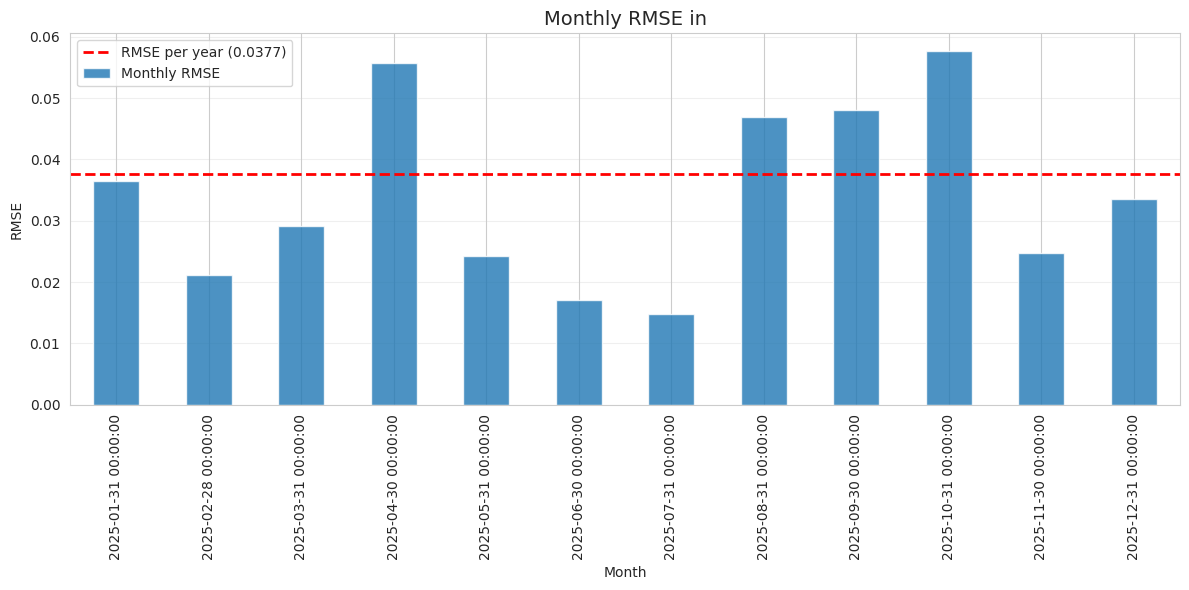

In [11]:
# Global prediction trend in 2025 per month
df_res = pd.DataFrame({
    'Actual': y_test,
    'Predicted': pred_test
}, index=y_test.index)

global_mse = mean_squared_error(y_test, pred_test)
global_rmse = np.sqrt(global_mse)
global_mae = mean_absolute_error(y_test, pred_test)

print("Global mean performance in 2025:")
print(f"RMSE: {global_rmse:.6f}")
print(f"MAE: {global_mae:.6f}")


# We need to calculate the RMSE and MAE on a subset of observations,
# so we define the following functions
def calculate_rmse(x):
    return np.sqrt(mean_squared_error(x['Actual'], x['Predicted']))

def calculate_mae(x):
    return mean_absolute_error(x['Actual'], x['Predicted'])

monthly_metrics = df_res.resample('ME').apply(lambda x: pd.Series({
    'RMSE': calculate_rmse(x),
    'MAE': calculate_mae(x),
    'Count': len(x)
}))

print("Errors per month")
print(monthly_metrics)

plt.figure(figsize=(12, 6))
monthly_metrics['RMSE'].plot(kind='bar', color='#1f77b4', alpha=0.8, label='Monthly RMSE')
plt.axhline(global_rmse, color='red', linestyle='--', linewidth=2, label=f'RMSE per year ({global_rmse:.4f})')

plt.title("Monthly RMSE in", fontsize=14)
plt.xlabel("Month")
plt.ylabel("RMSE")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Directional Accuracy : 76.11%
                  precision    recall  f1-score   support

Decrease - Short       1.00      0.02      0.04        55
 Increase - Long       0.76      1.00      0.86       171

        accuracy                           0.76       226
       macro avg       0.88      0.51      0.45       226
    weighted avg       0.82      0.76      0.66       226



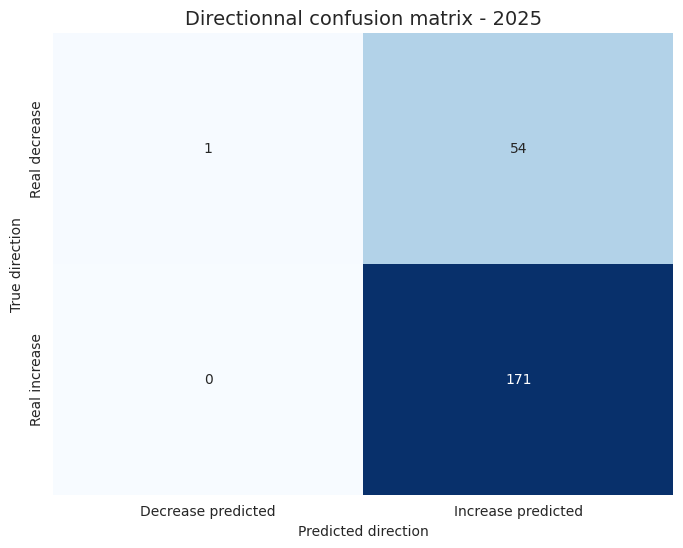

In [12]:
#Directional Accuracy

# We transform into binary signals our predictions: 1 = Increas, 0 = Decrease/Stability
y_test_dir = (y_test > 0).astype(int)
pred_test_dir = (pred_test > 0).astype(int)

acc = accuracy_score(y_test_dir, pred_test_dir)
print(f"Directional Accuracy : {acc*100:.2f}%")
# If it is above 50%, then the model performs better than the pure randomness (50%)

# Confusion matrix
print(classification_report(y_test_dir, pred_test_dir, target_names=['Decrease - Short', 'Increase - Long']))
cm = confusion_matrix(y_test_dir, pred_test_dir)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Decrease predicted', 'Increase predicted'],
            yticklabels=['Real decrease', 'Real increase'])
plt.title("Directionnal confusion matrix - 2025", fontsize=14)
plt.ylabel("True direction")
plt.xlabel("Predicted direction")
plt.show()

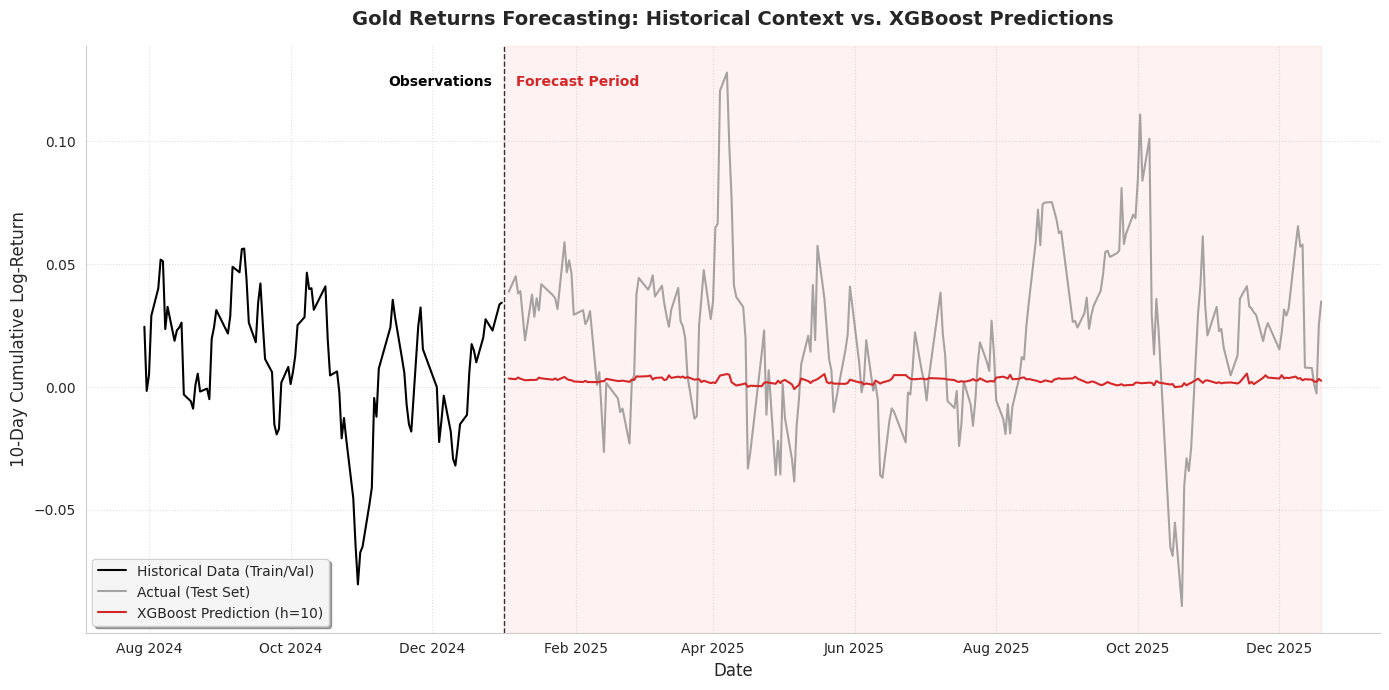

In [13]:
history_window = 100
history_series = y_val.iloc[-history_window:]

pred_series = pd.Series(pred_test, index=y_test.index)

fig, ax = plt.subplots(figsize=(14, 7), dpi=100)

ax.plot(history_series.index, history_series.values,
        color='black', linewidth=1.5, label='Historical Data (Train/Val)')

ax.plot(y_test.index, y_test.values,
        color='gray', linewidth=1.5, alpha=0.7, label='Actual (Test Set)')

ax.plot(pred_series.index, pred_series.values,
        color='#D62728', linewidth=1.5, linestyle='-', label='XGBoost Prediction (h=10)')

split_date = pd.to_datetime(TEST_START)
ax.axvline(split_date, color='black', linestyle='--', linewidth=1, alpha=0.8)

ylim_min, ylim_max = ax.get_ylim()
y_text_pos = ylim_max - (ylim_max - ylim_min) * 0.05

ax.text(split_date - pd.Timedelta(days=5), y_text_pos, 'Observations',
        ha='right', va='top', fontsize=10, fontweight='bold', color='black')
ax.text(split_date + pd.Timedelta(days=5), y_text_pos, 'Forecast Period',
        ha='left', va='top', fontsize=10, fontweight='bold', color='#D62728')

ax.axvspan(split_date, y_test.index[-1], color='red', alpha=0.05)

ax.set_title(f"Gold Returns Forecasting: Historical Context vs. XGBoost Predictions", fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel("10-Day Cumulative Log-Return", fontsize=12)
ax.set_xlabel("Date", fontsize=12)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=0)

ax.legend(loc='lower left', frameon=True, framealpha=0.9, shadow=True)
ax.grid(True, linestyle=':', alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

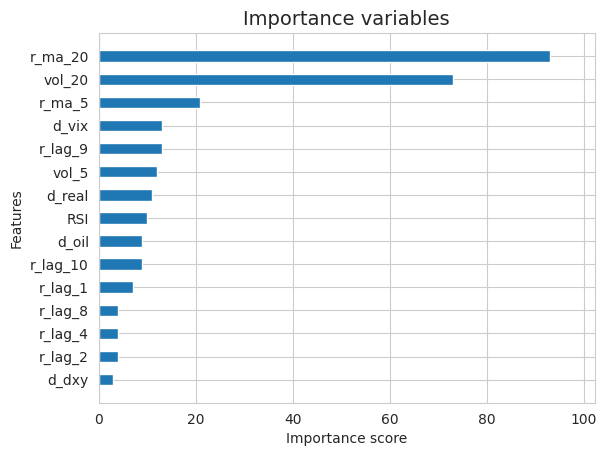

In [14]:
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, importance_type='weight', max_num_features=15, height=0.5, show_values=False)
plt.title("Importance variables", fontsize=14)
plt.show()

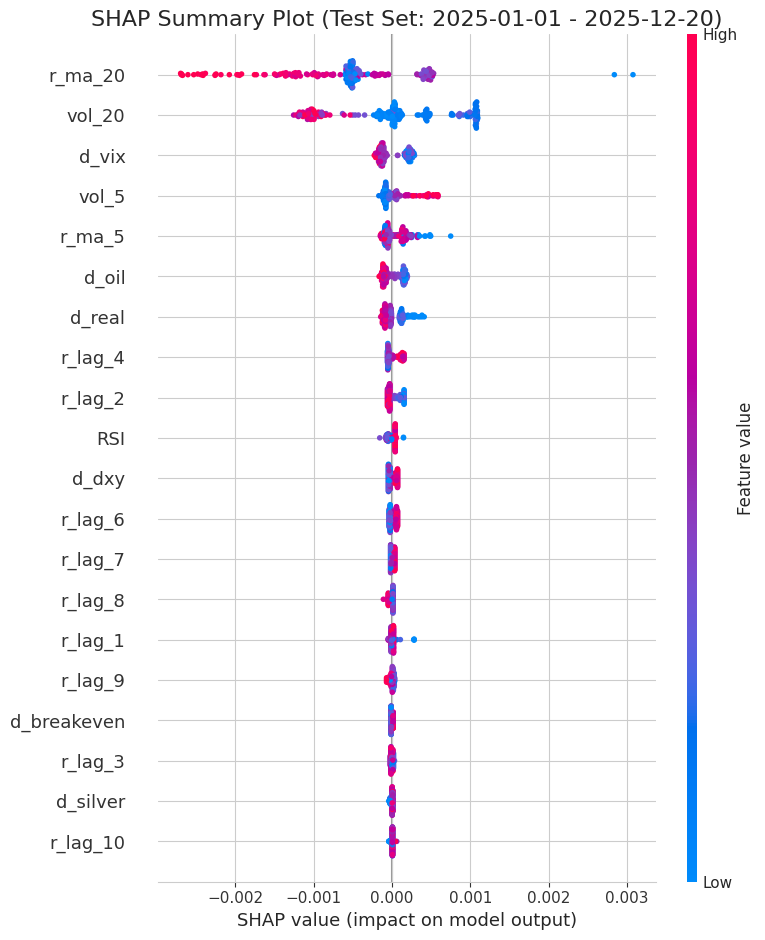

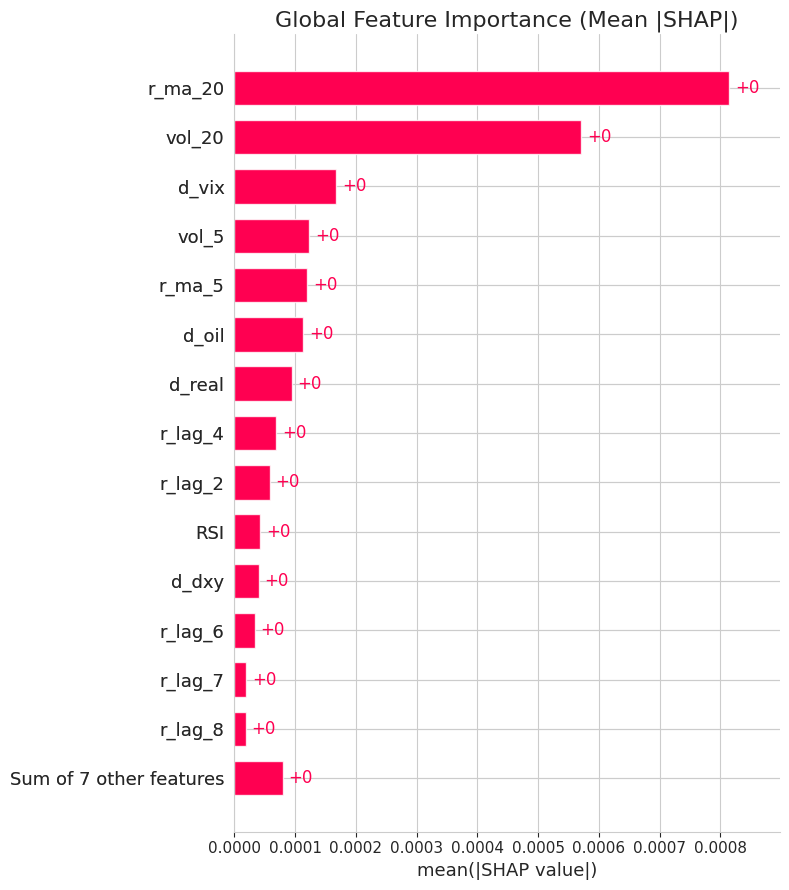

Génération du Dependence Plot pour : r_ma_20


<Figure size 1000x600 with 0 Axes>

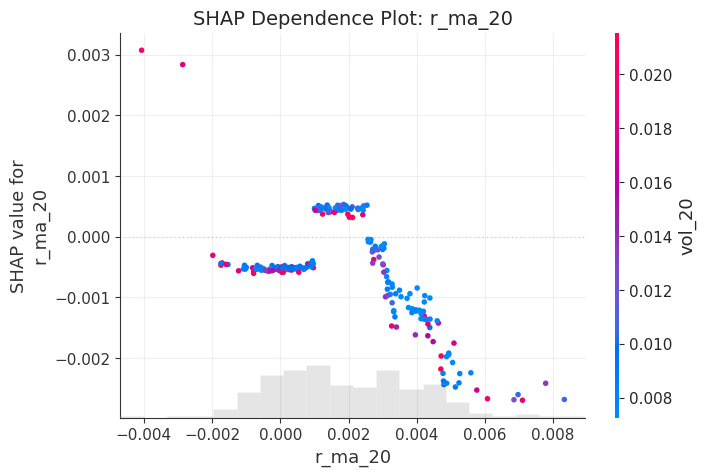

Génération du Dependence Plot pour : vol_20


<Figure size 1000x600 with 0 Axes>

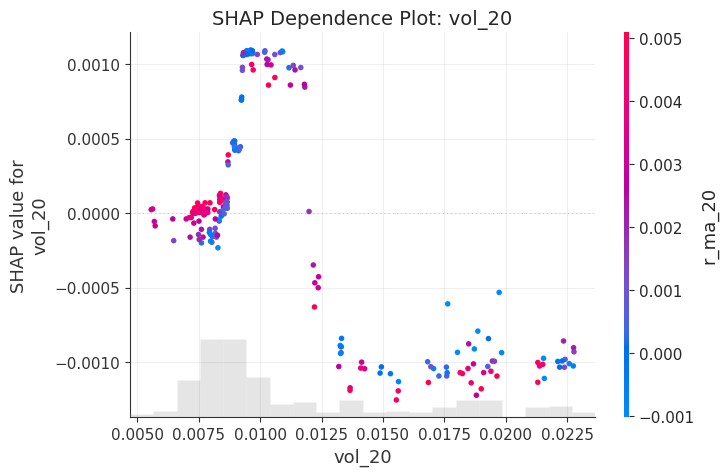

In [15]:

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title(f"SHAP Summary Plot (Test Set: {TEST_START} - {TEST_END})", fontsize=16)
plt.tight_layout()
plt.show()

# Absolute globale importane: real contribution on predictions
plt.figure(figsize=(10, 8))
shap.plots.bar(shap_values, max_display=15, show=False)
plt.title("Global Feature Importance (Mean |SHAP|)", fontsize=16)
plt.tight_layout()
plt.show()

top_features = X_test.columns[np.argsort(np.abs(shap_values.values).mean(0))][::-1]

for i in range(2):
    feat_name = top_features[i]
    print(f"Génération du Dependence Plot pour : {feat_name}")
    plt.figure(figsize=(10, 6))
    shap.plots.scatter(shap_values[:, feat_name], color=shap_values, show=False)
    plt.title(f"SHAP Dependence Plot: {feat_name}", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

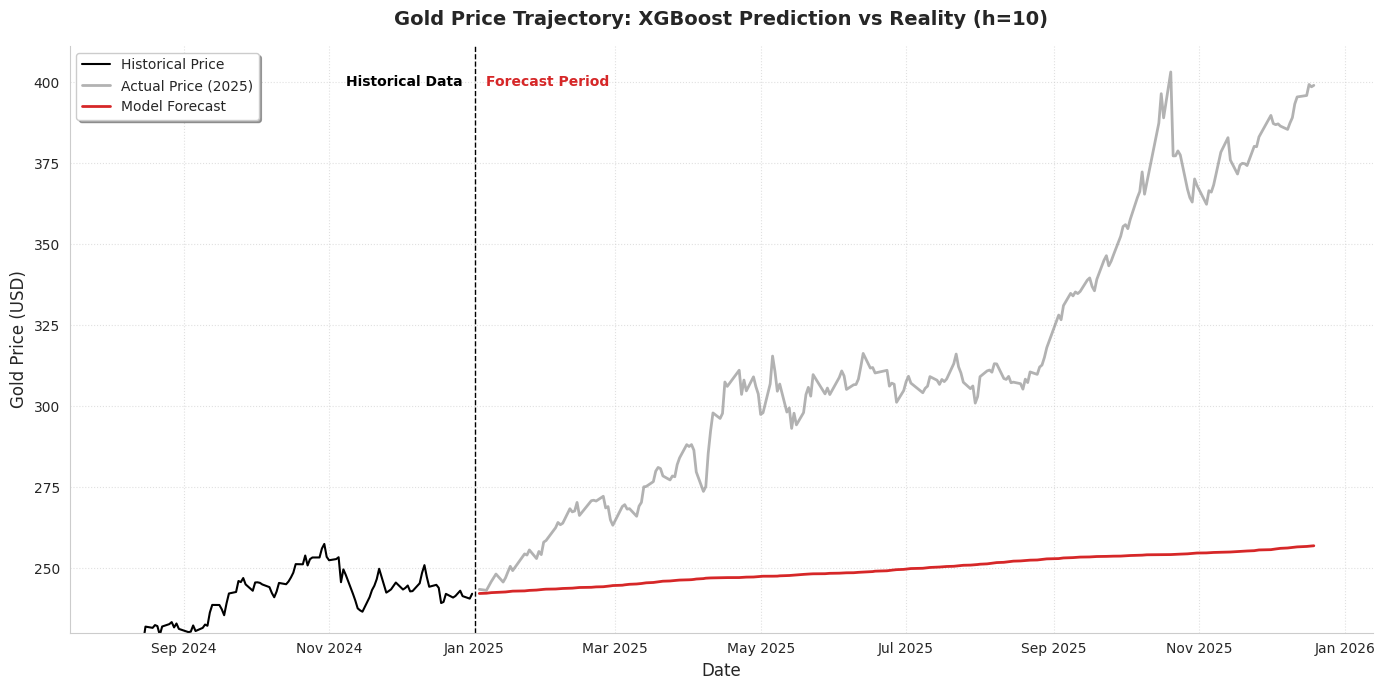

In [16]:
# Reconstructing Price to plot the predicted trend:
P0 = float(gld.loc[:TEST_START, "GLD_Close"].iloc[-1])

real_price_test = gld.loc[y_test.index, "GLD_Close"]

predicted_cum_returns = np.cumsum(pred_test / h)
predicted_values = P0 * np.exp(predicted_cum_returns)

predicted_price_series = pd.Series(predicted_values, index=y_test.index)

history_window = 100
history_price = gld.loc[:TEST_START].iloc[-history_window:]["GLD_Close"]

fig, ax = plt.subplots(figsize=(14, 7), dpi=100)

ax.plot(history_price.index, history_price.values,
        color='black', linewidth=1.5, label='Historical Price')

ax.plot(real_price_test.index, real_price_test.values,
        color='gray', linewidth=2, alpha=0.6, label='Actual Price (2025)')

ax.plot(predicted_price_series.index, predicted_price_series.values,
        color='#D62728', linewidth=2, linestyle='-', label='Model Forecast')

split_date = pd.to_datetime(TEST_START)
ax.axvline(split_date, color='black', linestyle='--', linewidth=1)

y_min_val = min(real_price_test.values.min(), predicted_price_series.values.min())
y_max_val = max(real_price_test.values.max(), predicted_price_series.values.max())

ylim_min = y_min_val * 0.95
ylim_max = y_max_val * 1.02
ax.set_ylim(ylim_min, ylim_max)

y_text_pos = ylim_max - (ylim_max - ylim_min) * 0.05
ax.text(split_date - pd.Timedelta(days=5), y_text_pos, 'Historical Data',
        ha='right', va='top', fontsize=10, fontweight='bold', color='black')
ax.text(split_date + pd.Timedelta(days=5), y_text_pos, 'Forecast Period',
        ha='left', va='top', fontsize=10, fontweight='bold', color='#D62728')

ax.set_title(f"Gold Price Trajectory: XGBoost Prediction vs Reality (h={h})", fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel("Gold Price (USD)", fontsize=12)
ax.set_xlabel("Date", fontsize=12)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

ax.legend(loc='upper left', frameon=True, shadow=True)
ax.grid(True, linestyle=':', alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [17]:
# Walk forward backtest:
params = best_params.copy()
params['n_jobs'] = -1


history_X = pd.concat([X_train, X_val])
history_y = pd.concat([y_train, y_val])

test_dates = X_test.index

wf_predictions = []
wf_dates = []


refit_step = 5

model_wf = xgb.XGBRegressor(**params)
model_wf.fit(history_X, history_y)


for i, date in tqdm(enumerate(test_dates), total=len(test_dates)):

    current_X = X_test.iloc[[i]]

    pred = model_wf.predict(current_X)[0]

    wf_predictions.append(pred)
    wf_dates.append(date)

    current_y = y_test.iloc[[i]]

    history_X = pd.concat([history_X, current_X])
    history_y = pd.concat([history_y, current_y])


    if (i + 1) % refit_step == 0:
        model_wf = xgb.XGBRegressor(**params)
        model_wf.fit(history_X, history_y)

pred_wf_series = pd.Series(wf_predictions, index=wf_dates)
y_true_wf = y_test.loc[wf_dates]

rmse_wf = np.sqrt(mean_squared_error(y_true_wf, pred_wf_series))
mae_wf = np.mean(np.abs(pred_wf_series - y_true_wf))

y_dir = (y_true_wf > 0).astype(int)
p_dir = (pred_wf_series > 0).astype(int)
acc_wf = accuracy_score(y_dir, p_dir)

print(f"RMSE Walk-Forward : {rmse_wf:.6f}")
print(f"MAE Walk-Forward  : {mae_wf:.6f}")
print(f"Directional Acc.  : {acc_wf*100:.2f}%")

print("\nClassification :")
print(classification_report(y_dir, p_dir, target_names=['Short', 'Long']))

100%|██████████| 226/226 [00:12<00:00, 17.57it/s]

RMSE Walk-Forward : 0.037309
MAE Walk-Forward  : 0.029668
Directional Acc.  : 75.22%

Classification :
              precision    recall  f1-score   support

       Short       0.40      0.04      0.07        55
        Long       0.76      0.98      0.86       171

    accuracy                           0.75       226
   macro avg       0.58      0.51      0.46       226
weighted avg       0.67      0.75      0.66       226

